In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
import pickle

### 1. Load Data

In [2]:
df_test = pd.read_csv("nyc-taxi-trip-duration/test.csv")
df_train = pd.read_csv("nyc-taxi-trip-duration/train.csv")
df_sample = pd.read_csv("nyc-taxi-trip-duration/sample_submission.csv")

### 2. Exploratory data analysis

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


###### As you can see there's a maximum data of 3526282 seconds, whic actually make zero sense. Who will take a taxi trip arround new york for roghly 980 hours. And there is also minimum trip duration of 1 seconds, which wont get you anywhere, this why there is some outliers need to be deal with. 

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [6]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             625134 non-null  object
 1   trip_duration  625134 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


#### 3. Data preparation

3.1 Trip duration clean-up

In [7]:
m = np.mean(df_train['trip_duration'])
s = np.std(df_train['trip_duration'])
df_train = df_train[df_train['trip_duration'] <= m + 2*s]
df_train = df_train[df_train['trip_duration'] >= m - 2*s]

Since we use nyc taxi data we want to exclude every pickoff and dropoff that are outside nyc borders.

In [8]:
df_train = df_train[df_train['pickup_longitude'] <= -73.75]
df_train = df_train[df_train['pickup_longitude'] >= -74.03]
df_train = df_train[df_train['pickup_latitude'] <= 40.85]
df_train = df_train[df_train['pickup_latitude'] >= 40.63]
df_train = df_train[df_train['dropoff_longitude'] <= -73.75]
df_train = df_train[df_train['dropoff_longitude'] >= -74.03]
df_train= df_train[df_train['dropoff_latitude'] <= 40.85]
df_train = df_train[df_train['dropoff_latitude'] >= 40.63]

3.3 Date Clean-up

As a final step in preparting data we need to change the formatting date.

In [9]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)

df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date

df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)

In [10]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


In [11]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30


In [12]:
#Convert character variables to numeric 
f = lambda x: 0 if x == 'N' else 1

df_train["store_and_fwd_flag"] =df_train["store_and_fwd_flag"].apply(lambda x: f(x))

3 Data Visualisation and Analysis

3.1 Initial Analysis

##### Histogram plot of Trip Duration

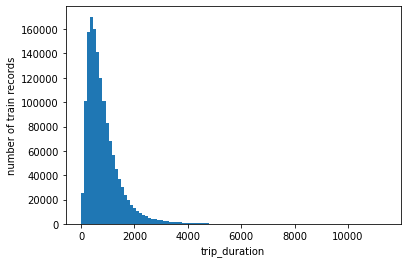

In [13]:
plt.hist(df_train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Let's see the number of trips over time this might reveal apparent season in the data and certain trends, so we could point out any significant outliers. Check if there are any trend/seasonality in both test and train data set, and also check wheter both data set follow the same pattern shape

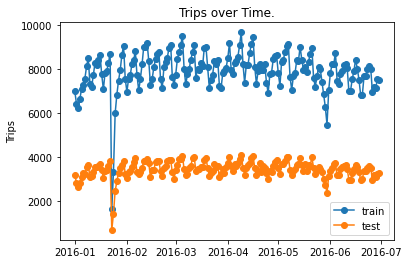

In [14]:
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(df_test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

let's see for posible outliers from taxi vendor prespective since there might be significant trip durations between taxi vendor in this data set

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

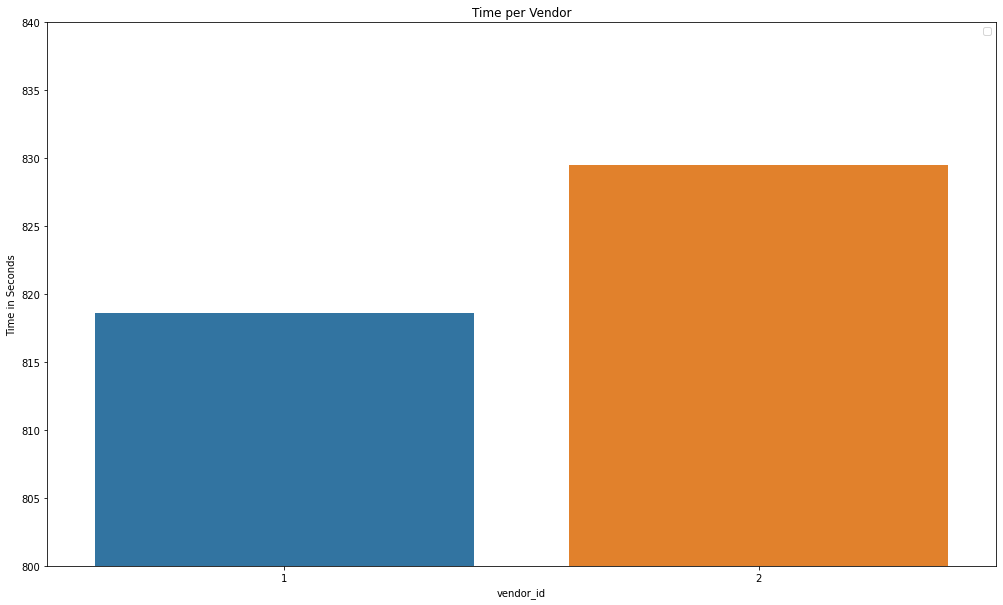

In [15]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = df_train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

let's check wheter test and train data matches with respect to number of trips

In [16]:
df_train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [17]:
df_test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

So as we can see there is some data that not present in train data set, this just prove that's there are more possible outliers in the data set

#### 3.2 Coordinate Mapping

##### 3.2.1 Pick Up Location

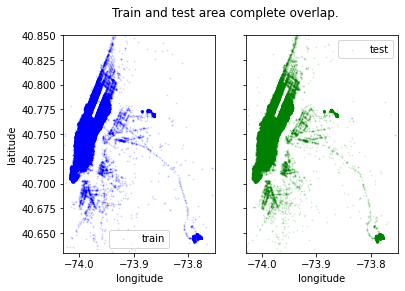

In [18]:
city_long_border = (-74.03, -73.75) # nyc longtitude border
city_lat_border = (40.63, 40.85) # nyc latitude border
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:100000], df_train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:100000], df_test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

The pickup locations are quite similar, with the notable difference being that the train data set simply has more data points 

##### 3.2.2  Distance and directionality

In [19]:
#def get_distance(source_lat, source_long, dest_lat, dest_long):
    # Returns the distance in Miles between the source and the destination.
    
    #distance = geodesic((source_lat, source_long), 
                        ##(dest_lat, dest_long)).km
    #return distance



In [20]:
#Get latitude and longitude differences 
df_train["latitude_difference"] = df_train["dropoff_latitude"] - df_train["pickup_latitude"]
df_train["longitude_difference"] = df_train["dropoff_longitude"] - df_train["pickup_longitude"]

In [21]:
#Convert trip distance from longitude and latitude differences to Manhattan distance.
df_train["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_train["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_train["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_train["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_train["longitude_difference"]) * np.pi / 180) / 2)))))))

In [22]:
df_train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,2016-03-14,-0.002,0.018,1.372
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,2016-06-12,-0.007,-0.019,1.829
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,2016-01-19,-0.054,-0.026,5.538
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2016-04-06,-0.013,-0.002,1.070
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,2016-03-26,-0.011,0.000,0.747


#### 4. Data extraction & featuring

In [23]:
# Extracting variables, like month, date, etc.
df_train["pickup_month"] = df_train["pickup_datetime"].dt.month
df_train["pickup_day"] = df_train["pickup_datetime"].dt.day
df_train["pickup_weekday"] = df_train["pickup_datetime"].dt.weekday #sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
df_train["pickup_hour"] = df_train["pickup_datetime"].dt.hour
df_train["pickup_minute"] = df_train["pickup_datetime"].dt.minute

In [24]:
df_train.groupby('pickup_month').size(),df_test.groupby('pickup_month').size()

(pickup_month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64,
 pickup_month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

#### Both train and test data sets have 6 months, so months are ready for dummy variables (i.e. encoding)

In [25]:
df_train["trip_duration"] = df_train["trip_duration"].apply(lambda x: round(x/60))

#### 5. Data enrichment

#### 6. Modelling

In [26]:
X = df_train.drop(["trip_duration", "id", "vendor_id", "pickup_datetime","pickup_date", "dropoff_datetime"], axis=1)
y = df_train["trip_duration"]

In [27]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)


In [28]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [29]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

watchlist = [(dtrain, 'train'), (dval, 'valid')]

In [30]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [31]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = 2000,
                evals = watchlist,
                verbose_eval = True
                )

[10:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feval", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1.98136	valid-rmse:1.97961
[1]	train-rmse:1.88544	valid-rmse:1.88382
[2]	train-rmse:1.79451	valid-rmse:1.79304
[3]	train-rmse:1.71106	valid-rmse:1.70974
[4]	train-rmse:1.62934	valid-rmse:1.62813
[5]	train-rmse:1.55146	valid-rmse:1.55039
[6]	train-rmse:1.47814	valid-rmse:1.47713
[7]	train-rmse:1.40829	valid-rmse:1.40749
[8]	train-rmse:1.34225	valid-rmse:1.34167
[9]	train-rmse:1.28100	valid-rmse:1.28055
[10]	tra

[176]	train-rmse:0.20740	valid-rmse:0.28498
[177]	train-rmse:0.20719	valid-rmse:0.28497
[178]	train-rmse:0.20669	valid-rmse:0.28486
[179]	train-rmse:0.20654	valid-rmse:0.28487
[180]	train-rmse:0.20639	valid-rmse:0.28481
[181]	train-rmse:0.20572	valid-rmse:0.28460
[182]	train-rmse:0.20533	valid-rmse:0.28452
[183]	train-rmse:0.20504	valid-rmse:0.28449
[184]	train-rmse:0.20460	valid-rmse:0.28433
[185]	train-rmse:0.20427	valid-rmse:0.28430
[186]	train-rmse:0.20395	valid-rmse:0.28427
[187]	train-rmse:0.20382	valid-rmse:0.28422
[188]	train-rmse:0.20368	valid-rmse:0.28421
[189]	train-rmse:0.20352	valid-rmse:0.28417
[190]	train-rmse:0.20345	valid-rmse:0.28418
[191]	train-rmse:0.20324	valid-rmse:0.28414
[192]	train-rmse:0.20277	valid-rmse:0.28398
[193]	train-rmse:0.20256	valid-rmse:0.28397
[194]	train-rmse:0.20221	valid-rmse:0.28391
[195]	train-rmse:0.20210	valid-rmse:0.28387
[196]	train-rmse:0.20168	valid-rmse:0.28377
[197]	train-rmse:0.20133	valid-rmse:0.28368
[198]	train-rmse:0.20120	valid-r

[363]	train-rmse:0.17581	valid-rmse:0.28049
[364]	train-rmse:0.17575	valid-rmse:0.28049
[365]	train-rmse:0.17569	valid-rmse:0.28049
[366]	train-rmse:0.17566	valid-rmse:0.28049
[367]	train-rmse:0.17544	valid-rmse:0.28048
[368]	train-rmse:0.17514	valid-rmse:0.28046
[369]	train-rmse:0.17504	valid-rmse:0.28045
[370]	train-rmse:0.17498	valid-rmse:0.28046
[371]	train-rmse:0.17469	valid-rmse:0.28041
[372]	train-rmse:0.17467	valid-rmse:0.28041
[373]	train-rmse:0.17448	valid-rmse:0.28039
[374]	train-rmse:0.17420	valid-rmse:0.28038
[375]	train-rmse:0.17415	valid-rmse:0.28038
[376]	train-rmse:0.17400	valid-rmse:0.28036
[377]	train-rmse:0.17386	valid-rmse:0.28036
[378]	train-rmse:0.17376	valid-rmse:0.28035
[379]	train-rmse:0.17367	valid-rmse:0.28034
[380]	train-rmse:0.17364	valid-rmse:0.28034
[381]	train-rmse:0.17351	valid-rmse:0.28032
[382]	train-rmse:0.17348	valid-rmse:0.28031
[383]	train-rmse:0.17330	valid-rmse:0.28030
[384]	train-rmse:0.17327	valid-rmse:0.28031
[385]	train-rmse:0.17303	valid-r

[550]	train-rmse:0.15524	valid-rmse:0.27901
[551]	train-rmse:0.15517	valid-rmse:0.27901
[552]	train-rmse:0.15498	valid-rmse:0.27901
[553]	train-rmse:0.15485	valid-rmse:0.27901
[554]	train-rmse:0.15481	valid-rmse:0.27901
[555]	train-rmse:0.15471	valid-rmse:0.27901
[556]	train-rmse:0.15469	valid-rmse:0.27901
[557]	train-rmse:0.15459	valid-rmse:0.27900
[558]	train-rmse:0.15454	valid-rmse:0.27900
[559]	train-rmse:0.15447	valid-rmse:0.27899
[560]	train-rmse:0.15442	valid-rmse:0.27899
[561]	train-rmse:0.15437	valid-rmse:0.27899
[562]	train-rmse:0.15426	valid-rmse:0.27898
[563]	train-rmse:0.15419	valid-rmse:0.27897
[564]	train-rmse:0.15414	valid-rmse:0.27897
[565]	train-rmse:0.15407	valid-rmse:0.27897
[566]	train-rmse:0.15402	valid-rmse:0.27897
[567]	train-rmse:0.15397	valid-rmse:0.27897
[568]	train-rmse:0.15389	valid-rmse:0.27896
[569]	train-rmse:0.15375	valid-rmse:0.27896
[570]	train-rmse:0.15369	valid-rmse:0.27896
[571]	train-rmse:0.15357	valid-rmse:0.27896
[572]	train-rmse:0.15345	valid-r

[737]	train-rmse:0.14063	valid-rmse:0.27841
[738]	train-rmse:0.14058	valid-rmse:0.27841
[739]	train-rmse:0.14054	valid-rmse:0.27841
[740]	train-rmse:0.14048	valid-rmse:0.27841
[741]	train-rmse:0.14038	valid-rmse:0.27840
[742]	train-rmse:0.14034	valid-rmse:0.27840
[743]	train-rmse:0.14033	valid-rmse:0.27840
[744]	train-rmse:0.14027	valid-rmse:0.27840
[745]	train-rmse:0.14019	valid-rmse:0.27840
[746]	train-rmse:0.14008	valid-rmse:0.27838
[747]	train-rmse:0.14002	valid-rmse:0.27838
[748]	train-rmse:0.13997	valid-rmse:0.27838
[749]	train-rmse:0.13992	valid-rmse:0.27838
[750]	train-rmse:0.13982	valid-rmse:0.27838
[751]	train-rmse:0.13980	valid-rmse:0.27837
[752]	train-rmse:0.13975	valid-rmse:0.27837
[753]	train-rmse:0.13962	valid-rmse:0.27837
[754]	train-rmse:0.13960	valid-rmse:0.27837
[755]	train-rmse:0.13952	valid-rmse:0.27837
[756]	train-rmse:0.13950	valid-rmse:0.27837
[757]	train-rmse:0.13938	valid-rmse:0.27837
[758]	train-rmse:0.13928	valid-rmse:0.27836
[759]	train-rmse:0.13917	valid-r

[924]	train-rmse:0.12883	valid-rmse:0.27812
[925]	train-rmse:0.12871	valid-rmse:0.27810
[926]	train-rmse:0.12867	valid-rmse:0.27810
[927]	train-rmse:0.12861	valid-rmse:0.27810
[928]	train-rmse:0.12855	valid-rmse:0.27810
[929]	train-rmse:0.12853	valid-rmse:0.27810
[930]	train-rmse:0.12848	valid-rmse:0.27811
[931]	train-rmse:0.12836	valid-rmse:0.27810
[932]	train-rmse:0.12828	valid-rmse:0.27810
[933]	train-rmse:0.12821	valid-rmse:0.27810
[934]	train-rmse:0.12813	valid-rmse:0.27810
[935]	train-rmse:0.12808	valid-rmse:0.27810
[936]	train-rmse:0.12800	valid-rmse:0.27809
[937]	train-rmse:0.12799	valid-rmse:0.27809
[938]	train-rmse:0.12790	valid-rmse:0.27808
[939]	train-rmse:0.12785	valid-rmse:0.27808
[940]	train-rmse:0.12779	valid-rmse:0.27808
[941]	train-rmse:0.12771	valid-rmse:0.27808
[942]	train-rmse:0.12770	valid-rmse:0.27808
[943]	train-rmse:0.12765	valid-rmse:0.27808
[944]	train-rmse:0.12761	valid-rmse:0.27808
[945]	train-rmse:0.12751	valid-rmse:0.27808
[946]	train-rmse:0.12737	valid-r

[1108]	train-rmse:0.11915	valid-rmse:0.27793
[1109]	train-rmse:0.11903	valid-rmse:0.27793
[1110]	train-rmse:0.11897	valid-rmse:0.27793
[1111]	train-rmse:0.11895	valid-rmse:0.27793
[1112]	train-rmse:0.11892	valid-rmse:0.27793
[1113]	train-rmse:0.11887	valid-rmse:0.27793
[1114]	train-rmse:0.11880	valid-rmse:0.27793
[1115]	train-rmse:0.11877	valid-rmse:0.27793
[1116]	train-rmse:0.11876	valid-rmse:0.27793
[1117]	train-rmse:0.11872	valid-rmse:0.27793
[1118]	train-rmse:0.11866	valid-rmse:0.27793
[1119]	train-rmse:0.11858	valid-rmse:0.27793
[1120]	train-rmse:0.11853	valid-rmse:0.27793
[1121]	train-rmse:0.11848	valid-rmse:0.27793
[1122]	train-rmse:0.11842	valid-rmse:0.27793
[1123]	train-rmse:0.11834	valid-rmse:0.27792
[1124]	train-rmse:0.11832	valid-rmse:0.27793
[1125]	train-rmse:0.11826	valid-rmse:0.27792
[1126]	train-rmse:0.11822	valid-rmse:0.27792
[1127]	train-rmse:0.11819	valid-rmse:0.27792
[1128]	train-rmse:0.11815	valid-rmse:0.27792
[1129]	train-rmse:0.11810	valid-rmse:0.27792
[1130]	tra

[1291]	train-rmse:0.11063	valid-rmse:0.27784
[1292]	train-rmse:0.11059	valid-rmse:0.27784
[1293]	train-rmse:0.11056	valid-rmse:0.27784
[1294]	train-rmse:0.11051	valid-rmse:0.27784
[1295]	train-rmse:0.11046	valid-rmse:0.27784
[1296]	train-rmse:0.11045	valid-rmse:0.27784
[1297]	train-rmse:0.11039	valid-rmse:0.27784
[1298]	train-rmse:0.11035	valid-rmse:0.27784
[1299]	train-rmse:0.11028	valid-rmse:0.27784
[1300]	train-rmse:0.11019	valid-rmse:0.27783
[1301]	train-rmse:0.11014	valid-rmse:0.27783
[1302]	train-rmse:0.11006	valid-rmse:0.27782
[1303]	train-rmse:0.10997	valid-rmse:0.27782
[1304]	train-rmse:0.10991	valid-rmse:0.27782
[1305]	train-rmse:0.10984	valid-rmse:0.27782
[1306]	train-rmse:0.10975	valid-rmse:0.27782
[1307]	train-rmse:0.10972	valid-rmse:0.27782
[1308]	train-rmse:0.10969	valid-rmse:0.27782
[1309]	train-rmse:0.10966	valid-rmse:0.27782
[1310]	train-rmse:0.10961	valid-rmse:0.27782
[1311]	train-rmse:0.10959	valid-rmse:0.27782
[1312]	train-rmse:0.10952	valid-rmse:0.27782
[1313]	tra

[1474]	train-rmse:0.10263	valid-rmse:0.27776
[1475]	train-rmse:0.10259	valid-rmse:0.27776
[1476]	train-rmse:0.10258	valid-rmse:0.27776
[1477]	train-rmse:0.10257	valid-rmse:0.27776
[1478]	train-rmse:0.10255	valid-rmse:0.27776
[1479]	train-rmse:0.10252	valid-rmse:0.27776
[1480]	train-rmse:0.10249	valid-rmse:0.27776
[1481]	train-rmse:0.10247	valid-rmse:0.27776
[1482]	train-rmse:0.10244	valid-rmse:0.27776
[1483]	train-rmse:0.10242	valid-rmse:0.27776
[1484]	train-rmse:0.10237	valid-rmse:0.27776
[1485]	train-rmse:0.10231	valid-rmse:0.27775
[1486]	train-rmse:0.10228	valid-rmse:0.27775
[1487]	train-rmse:0.10226	valid-rmse:0.27775
[1488]	train-rmse:0.10223	valid-rmse:0.27775
[1489]	train-rmse:0.10217	valid-rmse:0.27775
[1490]	train-rmse:0.10211	valid-rmse:0.27775
[1491]	train-rmse:0.10206	valid-rmse:0.27775
[1492]	train-rmse:0.10191	valid-rmse:0.27775
[1493]	train-rmse:0.10187	valid-rmse:0.27775
[1494]	train-rmse:0.10185	valid-rmse:0.27775
[1495]	train-rmse:0.10182	valid-rmse:0.27775
[1496]	tra

[1657]	train-rmse:0.09583	valid-rmse:0.27772
[1658]	train-rmse:0.09574	valid-rmse:0.27772
[1659]	train-rmse:0.09572	valid-rmse:0.27772
[1660]	train-rmse:0.09570	valid-rmse:0.27772
[1661]	train-rmse:0.09570	valid-rmse:0.27772
[1662]	train-rmse:0.09566	valid-rmse:0.27772
[1663]	train-rmse:0.09563	valid-rmse:0.27772
[1664]	train-rmse:0.09561	valid-rmse:0.27772
[1665]	train-rmse:0.09559	valid-rmse:0.27772
[1666]	train-rmse:0.09557	valid-rmse:0.27773
[1667]	train-rmse:0.09554	valid-rmse:0.27773
[1668]	train-rmse:0.09551	valid-rmse:0.27773
[1669]	train-rmse:0.09546	valid-rmse:0.27773
[1670]	train-rmse:0.09545	valid-rmse:0.27773
[1671]	train-rmse:0.09541	valid-rmse:0.27773
[1672]	train-rmse:0.09538	valid-rmse:0.27773
[1673]	train-rmse:0.09538	valid-rmse:0.27773
[1674]	train-rmse:0.09535	valid-rmse:0.27773
[1675]	train-rmse:0.09534	valid-rmse:0.27773
[1676]	train-rmse:0.09531	valid-rmse:0.27773
[1677]	train-rmse:0.09524	valid-rmse:0.27773
[1678]	train-rmse:0.09517	valid-rmse:0.27773
[1679]	tra

[1840]	train-rmse:0.08967	valid-rmse:0.27775
[1841]	train-rmse:0.08966	valid-rmse:0.27775
[1842]	train-rmse:0.08963	valid-rmse:0.27775
[1843]	train-rmse:0.08956	valid-rmse:0.27775
[1844]	train-rmse:0.08951	valid-rmse:0.27775
[1845]	train-rmse:0.08948	valid-rmse:0.27775
[1846]	train-rmse:0.08945	valid-rmse:0.27775
[1847]	train-rmse:0.08941	valid-rmse:0.27775
[1848]	train-rmse:0.08938	valid-rmse:0.27775
[1849]	train-rmse:0.08934	valid-rmse:0.27775
[1850]	train-rmse:0.08930	valid-rmse:0.27775
[1851]	train-rmse:0.08927	valid-rmse:0.27775
[1852]	train-rmse:0.08923	valid-rmse:0.27775
[1853]	train-rmse:0.08919	valid-rmse:0.27775
[1854]	train-rmse:0.08914	valid-rmse:0.27775
[1855]	train-rmse:0.08912	valid-rmse:0.27775
[1856]	train-rmse:0.08911	valid-rmse:0.27775
[1857]	train-rmse:0.08904	valid-rmse:0.27775
[1858]	train-rmse:0.08903	valid-rmse:0.27775
[1859]	train-rmse:0.08900	valid-rmse:0.27775
[1860]	train-rmse:0.08899	valid-rmse:0.27775
[1861]	train-rmse:0.08894	valid-rmse:0.27775
[1862]	tra

In [32]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [33]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

2.6377301390063788

In [34]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'trip_distance': 472400,
 'pickup_latitude': 766225,
 'pickup_minute': 394089,
 'pickup_weekday': 206787,
 'dropoff_longitude': 684523,
 'latitude_difference': 549151,
 'pickup_day': 358457,
 'passenger_count': 234271,
 'store_and_fwd_flag': 5593,
 'pickup_hour': 318672,
 'dropoff_latitude': 631772,
 'pickup_month': 201668,
 'pickup_longitude': 801160,
 'longitude_difference': 510236}

In [35]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))

In [87]:
pred.flatten()

array([13.104312, 10.459519,  7.905959, ..., 26.406984, 25.181149,
       20.13534 ], dtype=float32)

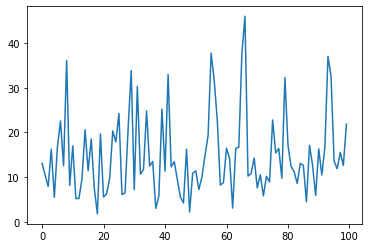

In [91]:
plt.plot(pred[0:100])
plt.show()

In [97]:
y

0           8
1          11
2          35
3           7
4           7
           ..
1458639    13
1458640    11
1458641    13
1458642     6
1458643     3
Name: trip_duration, Length: 1437128, dtype: int64

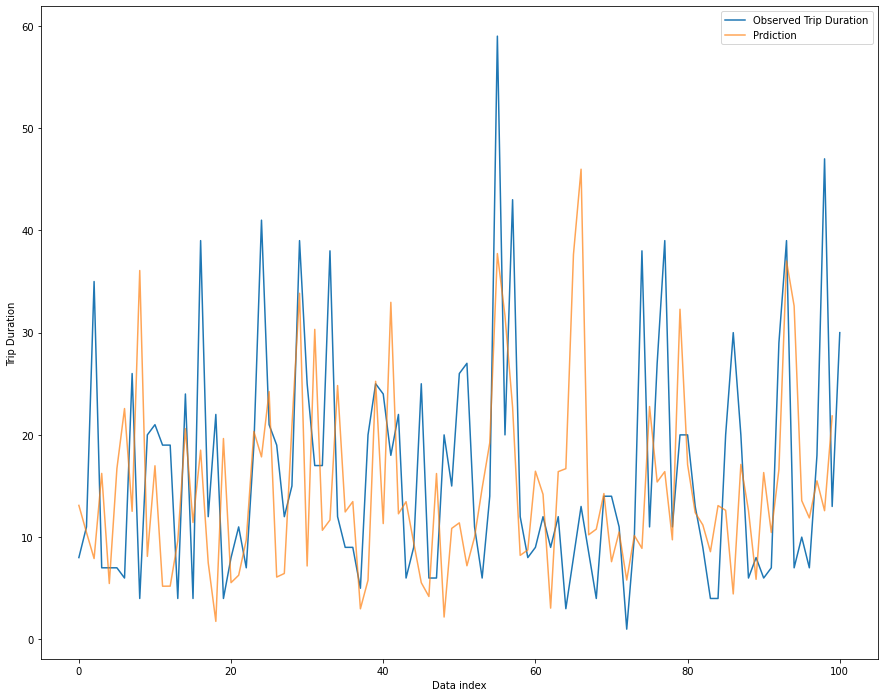

In [104]:
pred_frame= pd.DataFrame(data=pred)
plt.figure(figsize=(15,12))
ax = y.iloc[0:100].plot(label='Observed Trip Duration')
plt.plot(pred_frame[0].iloc[0:100],label='Prdiction',alpha=.7)

ax.set_xlabel('Data index')
ax.set_ylabel('Trip Duration')
plt.legend()
plt.show()


#### Model Evaluation

In [66]:
df_test = pd.read_csv("nyc-taxi-trip-duration/test.csv")

In [67]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


In [68]:
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date

In [69]:
df_test["latitude_difference"] = df_test["dropoff_latitude"] - df_test["pickup_latitude"]
df_test["longitude_difference"] = df_test["dropoff_longitude"] - df_test["pickup_longitude"]
df_test["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2)))))) + \
abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2)))))))

In [70]:
df_test["pickup_month"] = df_test["pickup_datetime"].dt.month
df_test["pickup_day"] = df_test["pickup_datetime"].dt.day
df_test["pickup_weekday"] = df_test["pickup_datetime"].dt.weekday #sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
df_test["pickup_hour"] = df_test["pickup_datetime"].dt.hour
df_test["pickup_minute"] = df_test["pickup_datetime"].dt.minute

In [71]:
f = lambda x: 0 if x == 'N' else 1

df_test["store_and_fwd_flag"] =df_test["store_and_fwd_flag"].apply(lambda x: f(x))

In [72]:
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)

In [73]:
df_test = df_test.drop(['pickup_datetime','pickup_date'],axis = 1)

In [74]:
df_test = df_test.drop(['id','vendor_id'],axis = 1)

In [75]:
df_test["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2)))))) + \
abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2)))))))

In [76]:
df_test = xgb.DMatrix(df_test)
pred = gbm.predict(df_test)
pred = np.exp(pred) - 1

In [77]:
pred

array([13.104312, 10.459519,  7.905959, ..., 26.406984, 25.181149,
       20.13534 ], dtype=float32)